In [23]:
from glob import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns

def fixpath(path):
    if path.startswith("C:"): return "/mnt/c/" + path.replace("\\", "/")[3:]
    else:
        pass
    return path

plt.rc('lines', linewidth=0.75)

#output_dir = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_hydro\base_COPPER_output")
output_dir = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_demand_supply\base_COPPER_scenarios")
os.chdir(output_dir)

dirs = glob(f'{output_dir}/*/', recursive=True)

scens = []
for dir in dirs:
    scen = dir.split('/')[-2]
    scens.append(scen)

scens

['BAU_emit',
 'BAU_emit_translimit',
 'BAU_zeroemit',
 'BAU_zeroemit_translimit',
 'ELEC_emit',
 'ELEC_emit_translimit',
 'ELEC_zeroemit',
 'ELEC_zeroemit_translimit']

In [31]:
caps_BC = pd.DataFrame()
caps_AB = pd.DataFrame()
for dir in dirs:
    os.chdir(dir)
    cap = pd.read_excel('Results_summary.xlsx', sheet_name='ABA_generation_mix', index_col=0) 
    cap_BC = cap.iloc[:,65]
    cap_AB = cap.iloc[:,66]
    caps_BC[f"BC_{dir.split('/')[-2]}"] = cap_BC
    caps_AB[f"AB_{dir.split('/')[-2]}"] = cap_AB
    os.chdir(output_dir)

caps_AB = caps_AB.iloc[:,[1,7]]
caps_BC = caps_BC.iloc[:,[1,7]]
base_cap = pd.read_excel(fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_hydro\base_COPPER_output\base_caps.xlsx"))
base_cap[['province', 'excess', 'gen_type']] = base_cap['ABA'].str.split('.',expand=True)
base_cap = base_cap.drop(['ABA','excess'], axis=1)
base_cap_BC = base_cap[base_cap['province'] == 'British Columbia']
base_cap_BC = base_cap_BC.drop(['province'], axis=1)
base_cap_BC = base_cap_BC.set_index('gen_type')
base_cap_AB = base_cap[base_cap['province'] == 'Alberta']
base_cap_AB = base_cap_AB.drop(['province'], axis=1)
base_cap_AB = base_cap_AB.set_index('gen_type')

caps = pd.concat([base_cap_BC.transpose(), caps_BC.transpose(), base_cap_AB.transpose(), caps_AB.transpose()], axis=0)
caps.replace(np.nan, 0, inplace=True)
caps.to_csv('caps.csv')

In [5]:
#General plot settings

gen_types = {
    'hydro': 'Hydro',
    'wind': 'Wind',
    'solar': 'Solar',
    'gasCC': 'Gas CC',
    'gasccs': 'Gas CCS',
    'coalccs': 'Coal CCS',
    'SMR': 'SMR',
    'nuclear': 'Nuclear',
    'gasSC': 'Gas SC',
    'coal' : 'Coal',
    'diesel': 'Diesel',
    'biomass': 'Biomass',
    'PHS': 'PHS',
    'LB': 'LB'
}

colors = {
    'hydro': '#a1c5ff',
    'wind': '#a9d6ae',
    'solar': '#fcfba9',
    'Wind': '#a9d6ae',
    'gasCC': '#a3a3a3',
    'gasccs': '#a3a3a3',
    'coalccs': '#a3a3a3',
    'SMR': '#a36594',
    'nuclear': '#664264',
    'gasSC': '#454545',
    'coal' : '#0d0d0d',
    'diesel': '#707070',
    'biomass': '#a8b3a2',
    'PHS': '#c4fcff',
    'LB': '#b8c3fc'
}

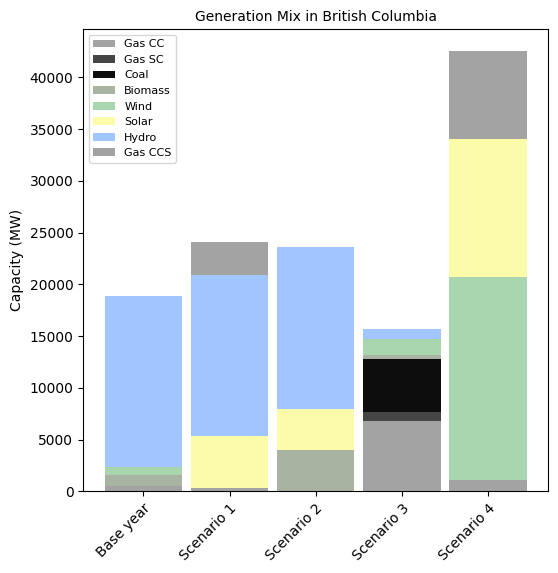

In [32]:
#Bar chart of generation mix in BC

BC_ch = caps.iloc[0:5]
BC_ch = BC_ch.loc[:, (BC_ch != 0).any(axis=0)]
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Generation Mix in British Columbia', fontsize=10)
ax.set_ylabel('Capacity (MW)', fontsize=10)
scen_labels = ['Base year', 'Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
BC_ch.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.9)
ax.set(xticklabels=scen_labels)
ax.legend(loc='upper left', fontsize=8, labels=[gen_types[i] for i in BC_ch.columns])
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=10, rotation_mode="anchor")
plt.savefig('BC_ch.png', dpi=300, bbox_inches='tight')

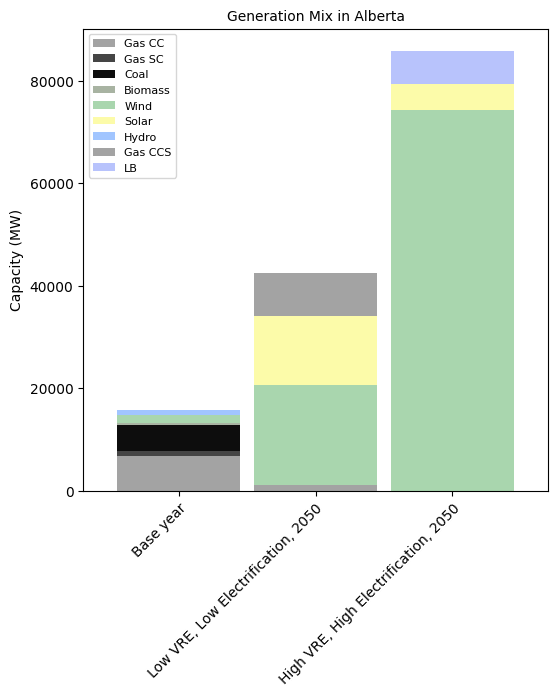

In [47]:
#Bar chart of generation mix in AB

caps.index = caps.index.astype('str')
AB_ch = caps.loc[(caps.index.str.contains('AB_')) | (caps.index.str.contains('2018'))]
AB_ch = AB_ch.iloc[1:4]
AB_ch = AB_ch.loc[:, (AB_ch != 0).any(axis=0)]
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Generation Mix in Alberta', fontsize=10)
ax.set_ylabel('Capacity (MW)', fontsize=10)
scen_labels = ['Base year', 'Low VRE, Low Electrification, 2050', 'High VRE, High Electrification, 2050']
AB_ch.plot(kind='bar', stacked=True, ax=ax, color=colors, align='center', width=0.9)
ax.set(xticklabels=scen_labels)
ax.legend(loc='upper left', fontsize=8, labels=[gen_types[i] for i in AB_ch.columns])
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=10, rotation_mode="anchor")
plt.savefig('AB_ch.png', dpi=300, bbox_inches='tight')

In [62]:
trans_list = []
for dir in dirs:
    os.chdir(dir)
    trans = pd.read_excel('Results_summary.xlsx', sheet_name='New_installed_transmission', index_col=0)
    ex_trans = pd.read_csv(fixpath(r"C:\Users\smoha\Documents\git\copper\COPPER7\extant_transmission.csv"))
    trans_list.append(round(trans.iloc[0,:].sum() + trans.iloc[2,:].sum() + ex_trans.iloc[0,7] + ex_trans.iloc[2,7],3))
    os.chdir(output_dir)
    
trans_scen = pd.DataFrame(trans_list, index=[i.split('/')[-2] for i in dirs], columns=['transmission (MW)'])
trans_scen = trans_scen.transpose()
trans_scen.insert(0, column='base year', value=2200)
trans_scen.to_excel('trans_scen.xlsx')

In [86]:
capcosts_BC = pd.DataFrame()
capcosts_AB = pd.DataFrame()
transcosts = []

for dir in dirs:
    os.chdir(dir)
    capcost = pd.read_excel('Results_summary.xlsx', sheet_name='ABA_investment_costs', index_col=0)
    transcost = pd.read_excel('Results_summary.xlsx', sheet_name='Transmission_investment', index_col=0)
    capcost_BC = capcost.iloc[:,0] + capcost.iloc[:,13] + capcost.iloc[:,26]
    capcost_AB = capcost.iloc[:,1] + capcost.iloc[:,14] + capcost.iloc[:,27]
    transcost = transcost.iloc[0,0] + transcost.iloc[0,2]
    transcosts.append(transcost)
    capcosts_BC[f"{dir.split('/')[-2]}"] = capcost_BC
    capcosts_AB[f"{dir.split('/')[-2]}"] = capcost_AB
    os.chdir(output_dir)

costs = pd.DataFrame()
costs['BC'] = capcosts_BC.sum(axis=0)
costs['AB'] = capcosts_AB.sum(axis=0)
costs['transmission'] = transcosts
costs['total'] = costs.sum(axis=1)

costs = round(costs/1000000,3)

costs_table = costs.transpose()
costs_table.columns=['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
costs_table.index=['Capacity Expansion Costs for BC', 'Capacity Expansion Costs for AB','Transmission Expansion Costs', 'Total']
costs_table.to_excel('costs_table.xlsx')

In [3]:
#To create the demand file for the national runs
demand_base = pd.read_csv('demand.csv', index_col=None, header=None)
demand_base.columns = ['BA', 'demand']
demand_base['demand'] = demand_base['demand'].astype(float)
provinces_full = {
            "British Columbia": "BC",
            "Alberta": "AB",
            "Manitoba": "MN",
            "New Brunswick": "NB",
            "Newfoundland and Labrador": "NL",
            "Nova Scotia": "NS",
            "Ontario": "ON",
            "Quebec": "QB",
            "Saskatchewan": "SK",
            "Prince Edward Island": "PE"
            }

demand_2050 = demand_base
demand_2050['demand'] = demand_base['demand']*1.5 #change to the desired growth rate
demand_file=pd.DataFrame()
for i, row in demand_2050.iterrows():
    demand_file.loc[f'{row["BA"].split(".")[-1]}',f'{provinces_full[row["BA"].split(".")[0]]}.a'] = row['demand']

In [4]:
pop_BA = pd.read_csv('pop_BA.csv', index_col=None, header=None)
pop_BA[['BA', 'rub', 'rub2', 'pop']] = pop_BA.iloc[:,0].str.split(' ', expand=True)
pop_BA = pop_BA.loc[:,['BA', 'pop']]
pop_BA.set_index('BA', inplace=True)
pop_BA = pop_BA.transpose()
pop_BA.loc['pop'] = pop_BA.loc['pop'].astype(float)
pop_BA

BA,AB.a,BC.a,MN.a,NB.a,NL.a,NL.b,NS.a,ON.a,ON.b,PE.a,QB.a,QB.b,SK.a
pop,3584417.0,4497392.0,1234225.0,717014.0,463818.0,68873.0,944301.0,10585358.0,1971750.0,140204.0,7365348.0,825681.0,1078184.0


In [5]:
nl_pop = {
    'NL.a' : pop_BA['NL.a']/(pop_BA['NL.a']+pop_BA['NL.b']),
    'NL.b' : pop_BA['NL.b']/(pop_BA['NL.a']+pop_BA['NL.b'])
    }
on_pop = {
    'ON.a' : pop_BA['ON.a']/(pop_BA['ON.a']+pop_BA['ON.b']),
    'ON.b' : pop_BA['ON.b']/(pop_BA['ON.a']+pop_BA['ON.b'])
    }
qb_pop = {
    'QB.a' : pop_BA['QB.a']/(pop_BA['QB.a']+pop_BA['QB.b']),
    'QB.b' : pop_BA['QB.b']/(pop_BA['QB.a']+pop_BA['QB.b'])
    }
demand_file.insert(loc = 5, column = 'NL.b', value=round(demand_file['NL.a']*nl_pop['NL.b'].values[0]))
demand_file['NL.a'] = round(demand_file['NL.a']*nl_pop['NL.a'].values[0])
demand_file.insert(loc = 8, column = 'ON.b', value=round(demand_file['ON.a']*on_pop['ON.b'].values[0]))
demand_file['ON.a'] = round(demand_file['ON.a']*on_pop['ON.a'].values[0])
demand_file.insert(loc = 11, column = 'QB.b', value=round(demand_file['QB.a']*qb_pop['QB.b'].values[0]))
demand_file['QB.a'] = round(demand_file['QB.a']*qb_pop['QB.a'].values[0])

demand_file['Total'] = demand_file.sum(axis=1)

demand_file.head()

,AB.a,BC.a,MN.a,NB.a,NL.a,NL.b,NS.a,ON.a,ON.b,PE.a,QB.a,QB.b,SK.a,Total
1,15454.5,14491.5,5784.2610,3856.5,2277.0,338.0,2532.0,26840.0,4999.0,276.0,39985.0,4482.0,4669.5,125985.2610
2,15133.5,15246.0,5636.7780,3793.5,2222.0,330.0,2545.5,25800.0,4806.0,259.5,39223.0,4397.0,4575.0,123967.7780
3,14883.0,14922.0,5456.5050,3702.0,2149.0,319.0,2556.0,24923.0,4642.0,249.0,38282.0,4291.0,4513.5,120888.0050
4,14592.0,14425.5,5297.2740,3580.5,2079.0,309.0,2559.0,24236.0,4514.0,235.5,36636.0,4107.0,4423.5,116994.2740
5,14278.5,14001.0,5059.2555,3465.0,2045.0,304.0,2465.1,23537.0,4384.0,277.5,35823.0,4016.0,4380.0,114035.3555


In [6]:
from openpyxl import load_workbook
import shutil

demand_prev = 'CA_Demand_Real_Forecasted.xlsx'
demand_new = 'CA_2050_Demand_Real_Forecasted.xlsx'
base_total = pd.read_excel('CA_Demand_Real_Forecasted.xlsx', sheet_name='Province_Total_Real', index_col=0)
zonal_total = pd.read_excel('CA_Demand_Real_Forecasted.xlsx', sheet_name='Zonal_Demand_Real', index_col=0)
demand_file.index = base_total.index
shutil.copy(demand_prev, demand_new)


base_total = demand_file['Total']
base_total.columns = ['demand']
zonal_total = demand_file
wb_target = load_workbook(demand_new, data_only=False)
del wb_target['Province_Total_Real']
del wb_target['Zonal_Demand_Real']
writer = pd.ExcelWriter(demand_new, engine='openpyxl')
writer.book = wb_target
base_total.to_excel(writer, sheet_name='Province_Total_Real')
zonal_total.to_excel(writer, sheet_name='Zonal_Demand_Real')
writer.close()
wb_target.close()

/tmp/ipykernel_1216/2472000438.py:19: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = wb_target
